Here I have one of the earliest versions of my code, but running on the GPU.

In [2]:
# Based on Kaggle code, importing libraries that may come in handy later on
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.regularizers import l2

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5821348466120287249
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12733280133712042444
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/AI UCM/IMDB Dataset.csv (1).zip')

# Convert sentiment to binary values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Step 1: Split the data into train + test and test sets (80% train/validation, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

# Step 2: Split the training data into training + validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Training size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Training size: 32000
Validation size: 8000
Test size: 10000


In [4]:
max_words = 20000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Fit tokenizer only on the training data

# Tokenize and pad each subset
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [5]:
# Building LSTM Model

# Binary classification uses sigmoid— binary-crossentropy
embedding_dim = 100


model = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(20, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    LSTM(20, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(20, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200, 20)             │           9,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 20)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,013,401 (7.68 MB)

 Trainable params: 2,013,401 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=32,
    validation_data=(X_val_pad, y_val)
)

Epoch 1/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.6530 - loss: 0.6423 - val_accuracy: 0.8789 - val_loss: 0.3178
Epoch 2/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.8780 - loss: 0.3481 - val_accuracy: 0.8854 - val_loss: 0.2952
Epoch 3/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9026 - loss: 0.2916 - val_accuracy: 0.8842 - val_loss: 0.3195
Epoch 4/4
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9147 - loss: 0.2600 - val_accuracy: 0.8829 - val_loss: 0.3124


In [7]:
# Print training and validation performance
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])


Training Accuracy: 0.9149062633514404
Validation Accuracy: 0.8828750252723694


In [8]:
# Test model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8814 - loss: 0.3063
Test Accuracy: 0.8851000070571899
Test Loss: 0.300713449716568


In [9]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_pad).ravel() > 0.5
print(classification_report(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4961
           1       0.93      0.84      0.88      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



Let's do some visualization!


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step


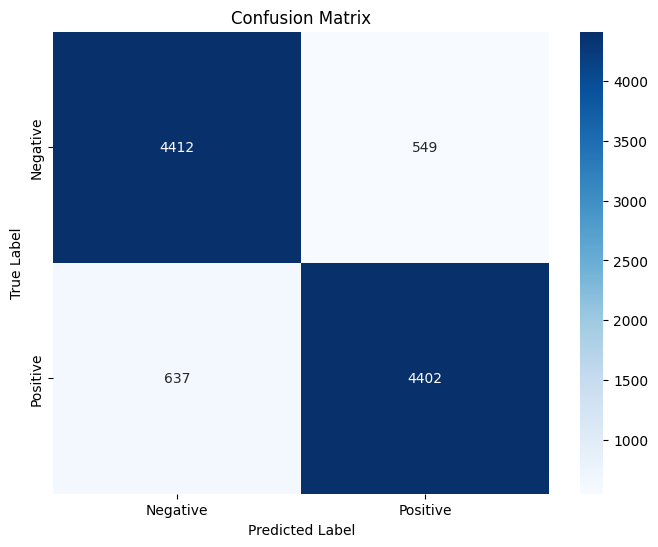

In [ ]:
# Predict class probabilities and threshold at 0.5
y_pred = model.predict(X_test_pad).ravel() > 0.5

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


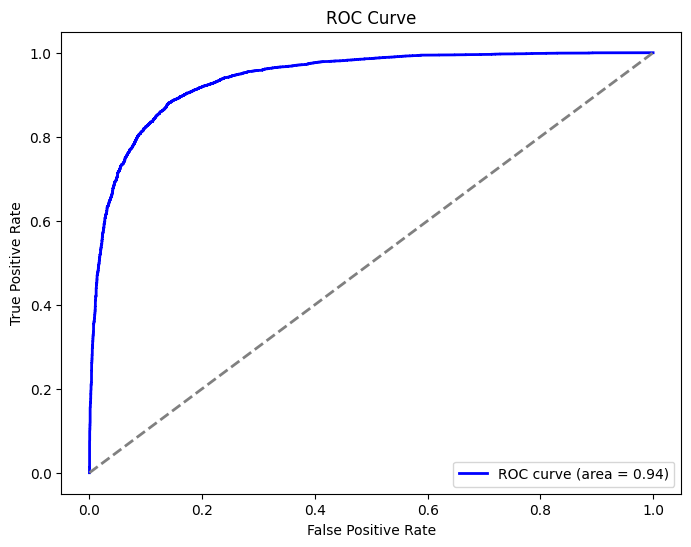

In [ ]:
# Get the predicted probabilities
y_pred_prob = model.predict(X_test_pad).ravel()

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


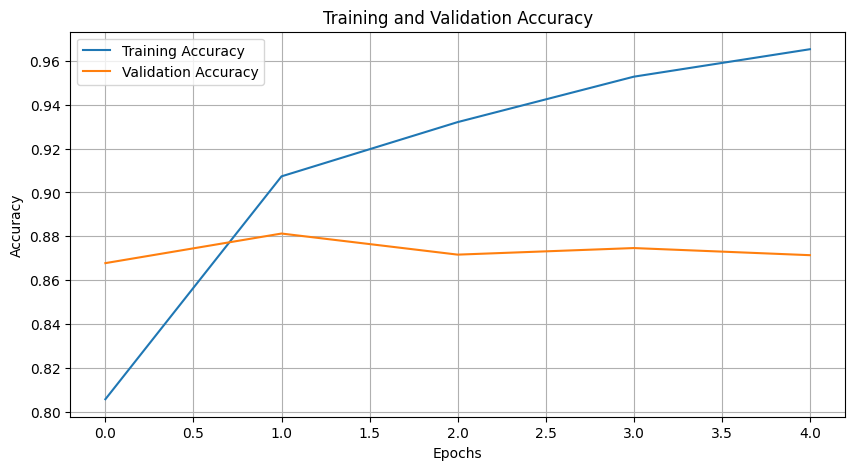

In [ ]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


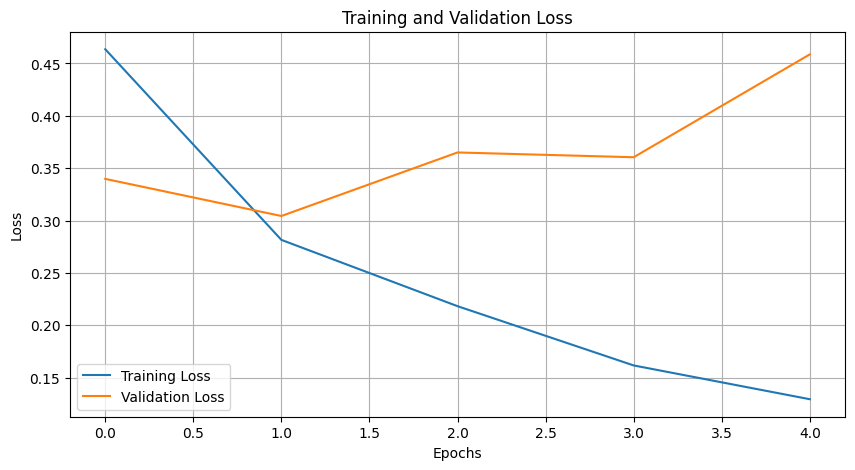

In [ ]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [12]:
# to predict new reviews:

def predict_sentiment(review):
    sequence = tokenizer.texts_to_sequences([review])
    padded = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded)[0][0]
    return "Positive" if prediction > 0.5 else "Negative"

new_review1 = "this movie was not the best"
new_review2 = "this movie was so boring"
new_review3 = "i left the theater early"
print(f"Sentiment: {predict_sentiment(new_review1)}")
print(f"Sentiment: {predict_sentiment(new_review3)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sentiment: Negative
